# **KERNEL METHODS**

In [63]:
import sys
sys.path.append("../scripts")


In [64]:
# Import libraries
from genham import hammersley
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from numpy.linalg import norm

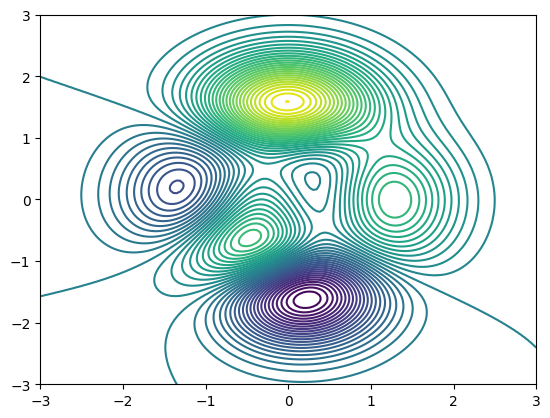

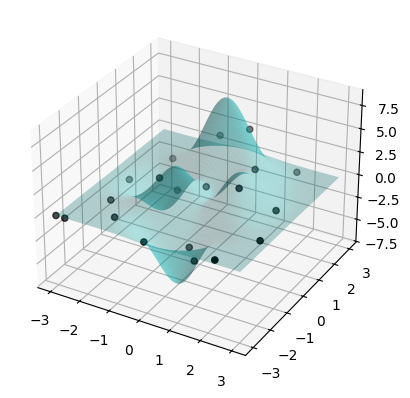

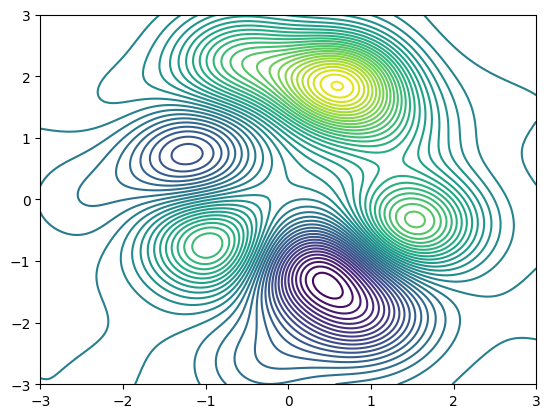

In [65]:
# Define the test surface ('ground truth)
def peaks(x,y):
    """Peaks function for testing
    Creates a bumpy 3D surface, often used as a test function in optimization & machine learning and matlab demos.

    Args: x (float): x-coordinate
          y (float): y-coordinate
          Returns: z (float): value of the peaks function at (x,y)"""
    z =  (3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) 
          - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2)
          - 1/3 * np.exp(-(x+1)**2 - y**2)) 
    return(z)

# Generate the data points using the Hammersley sequence 
n = 20 # number of training points
# use Hammersley sequence to generate points in 2D (like evenly spaced random points in [-3,3]^2)
x = -3 + 6*hammersley([2,3],n)
z = peaks(x[:,0],x[:,1]) # true values of the peaks function at the generated points

# Plot the true surface for reference
xx, yy = np.mgrid[-3:3:150j,-3:3:150j] # dense grid for plotting
zz = peaks(xx,yy)
plt.contour(xx,yy,zz,levels=50)

# Plotting the surface
fig=plt.figure()    # Create a new figure
ax = fig.add_subplot(111,projection='3d')   # Add a 3D subplot
ax.plot_surface(xx,yy,zz,rstride=1,cstride=1,color='c',alpha=0.3,linewidth=0)   # Set the surface color and transparency
ax.scatter(x[:,0],x[:,1],z,color='k',s=20)  # Scatter the points on the surface
plt.show()

# Define kernel regression training function
def kernel_train(k, n, x, y):
    """ Buils Gram matrix K and solves for alpha in kernel regression.
    
    Args:
        k (function): kernel function
        n (int): number of training points
        x (ndarray): training inputs, shape (n, d)
        y (ndarray): training outputs, shape (n, 1) 
        Returns:
        K (ndarray): Gram matrix, shape (n, n)
        alpha (ndarray): coefficients, shape (n, 1) 
        """
    K = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            K[i,j] = k(x[i,:],x[j])
    # Solve the linear system K @ alpha = y (weights of the kernel regression)
    alpha = np.linalg.solve(K@K.T, K@y)
    return K, alpha

# Define the kernel function (Gaussian kernel)
sig2 = 0.3 # kernel parameter (controls spread  of Gaussian kernel)
def k(x,u):
   return(np.exp(-0.5*norm(x- u)**2/sig2))

# Train the kernel regression model
K, alpha = kernel_train(k, n, x, z)

# Evaluate the model on a grid of points (test grid)
N, = xx.flatten().shape
Kx = np.zeros((n,N))
for i in range(n):
    for j in range(N):
        Kx[i,j] = k(x[i,:],np.array([xx.flatten()[j],yy.flatten()[j]]))
    
# Predict the output using the kernel regression model
# Predicted values = weghted sum of kernel evaluations at the training points
g = Kx.T @ alpha
dim = np.sqrt(N).astype(int)
yhat = g.reshape((dim,dim))

# Plot the predicted surface
plt.contour(xx,yy,yhat,levels=50)


#### Original Function:
- The peaks function is complex and highly non-linear, with multiple peaks and valleys.
- Training data points are sampled from this surface (shown as scattered black points). The kernel model’s task is to learn the underlying function from these samples.

### Question 1.2: What is the matrix K? 
The K matrix is the similarity matrix of the training points under the kernel which encodes all the geometry of your data in the kernel-defined feature space.It is a square table where each entry tells you how similar two training points are, according to the kernel function. This is the Gram Matrix of our kernel.

### Question 1.3a: What is the role of the kernel function k, and of the training set x in this algorithm?
The kernel function k is the rule for measuring similarity between two points. It decides the “shape” of the similarity, for example using a Gaussian, polynomial, or linear comparison. The training set x provides the anchor points where these kernel functions are centred. Together, they let us express the learned function as a weighted sum of kernels around the training points.

### Question 1.3b: How does it relate to the theory in the videos?
This matches the Representer Theorem: the solution in a kernel method is always a combination of kernels evaluated at the training data. The training inputs x set the basis, and the kernel k defines how those basis functions interact.

### Question 1.4a: How could one plot the final trained function?
To plot the trained function, you take a grid of points covering the input space, compute their similarity to the training points using the kernel, and then combine these similarities with the learned weights. The results give predicted values across the grid, which can be plotted as a contour plot or surface plot.

### Question 1.4b: How could one test the resulting function on a novel test set?
To test on new data, you do the same process: calculate the kernel values between the new test points and the training points, then multiply by the learned weights. This gives the predicted outputs for the unseen test inputs.

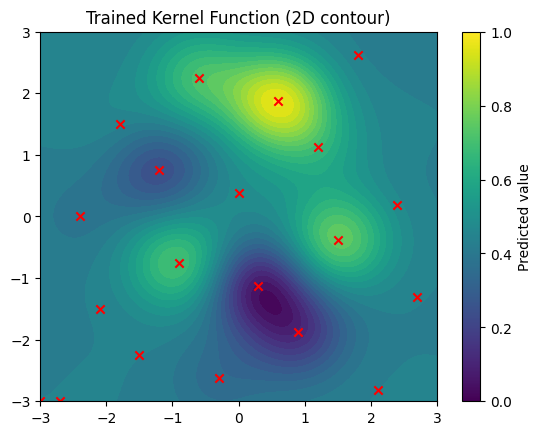

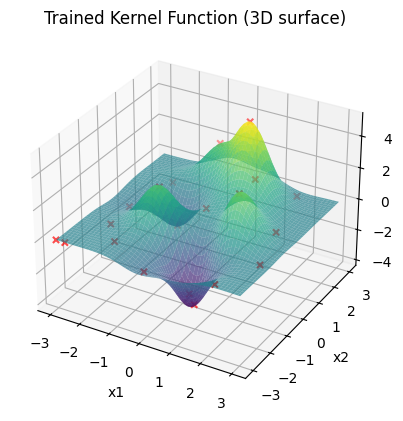

Predictions on test points: [0.25173388 2.13987662 0.27687637]


In [66]:
# Plotting the surface
def predict(x_train, alpha, k, x_new):
    """Predict outputs for new points using trained kernel regression."""
    n = x_train.shape[0]
    m = x_new.shape[0]
    K_new = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            K_new[i,j] = k(x_train[i,:], x_new[j,:])
    return (K_new.T @ alpha).reshape(-1,1)

# Grid for plotting
grid_points = np.c_[xx.ravel(), yy.ravel()]
yhat = predict(x, alpha, k, grid_points).reshape(xx.shape)

# 2D contour plot
plt.figure()
plt.contourf(xx, yy, yhat, levels=30, cmap='viridis')
plt.scatter(x[:,0], x[:,1], c='red', marker='x')  # training points
plt.title("Trained Kernel Function (2D contour)")
plt.colorbar(label="Predicted value")
plt.show()

# 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, yhat, cmap='viridis', alpha=0.7)
ax.scatter(x[:,0], x[:,1], z, c='red', marker='x')  # training points with true z
ax.set_title("Trained Kernel Function (3D surface)")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("prediction")
plt.show()

# Test on a small novel test set
x_test = np.array([[0,0], [1,1], [-2,2]])
y_pred = predict(x, alpha, k, x_test)
print("Predictions on test points:", y_pred.ravel())



### Observations on new data
#### Trained Kernel Function (Second Plots):
- The trained kernel regression surface (yhat) captures the main shape of the original peaks function. Key features (peaks and valleys) are well approximated.
- Red “x” markers show training points. The model fits close to these, consistent with how kernel methods use each point in prediction.
- The learned surface is smooth and continuous, reflecting the Gaussian (RBF) kernel’s properties.
- Visual comparison shows the trained model generalizes well to unseen inputs within the same domain. Predictions for test points confirm it can extend beyond the training set.

### Takeaway:
The plots confirm that kernel regression with a Gaussian kernel can learn and approximate a complex, non-linear function. It captures the underlying structure from the training data and provides smooth predictions that generalize to new inputs.

Linear kernel Gram matrix:
 [[0. 0. 0. 0.]
 [0. 1. 0. 1.]
 [0. 0. 1. 1.]
 [0. 1. 1. 2.]] 

Polynomial kernel (degree=3) Gram matrix:
 [[ 1.  1.  1.  1.]
 [ 1.  8.  1.  8.]
 [ 1.  1.  8.  8.]
 [ 1.  8.  8. 27.]] 

Gaussian kernel Gram matrix:
 [[1.         0.13533528 0.13533528 0.01831564]
 [0.13533528 1.         0.01831564 0.13533528]
 [0.13533528 0.01831564 1.         0.13533528]
 [0.01831564 0.13533528 0.13533528 1.        ]] 



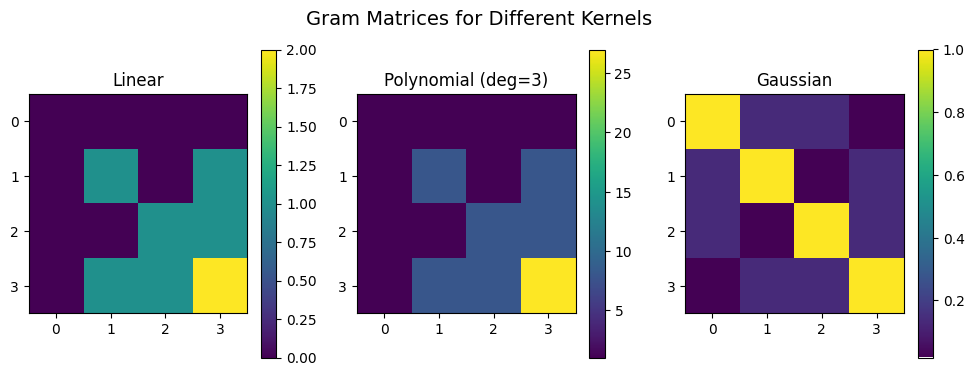

In [67]:
# Define extra kernels
def linear_kernel(x, u):
    return np.dot(x, u)

def poly_kernel(x, u, degree=3):
    return (1 + np.dot(x, u)) ** degree

def gaussian_kernel(x, u, sigma=0.3):
    return np.exp(-0.5 * norm(x - u)**2 / sigma**2)

# Small training set for illustration
x_small = np.array([[0,0],[1,0],[0,1],[1,1]])

# Function to build Gram matrix
def gram_matrix(k, X):
    n = X.shape[0]
    K = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            K[i,j] = k(X[i,:], X[j,:])
    return K

# Compute Gram matrices
K_linear = gram_matrix(linear_kernel, x_small)
K_poly   = gram_matrix(lambda a,b: poly_kernel(a,b,degree=3), x_small)
K_gauss  = gram_matrix(lambda a,b: gaussian_kernel(a,b,sigma=0.5), x_small)

# Display results
print("Linear kernel Gram matrix:\n", K_linear, "\n")
print("Polynomial kernel (degree=3) Gram matrix:\n", K_poly, "\n")
print("Gaussian kernel Gram matrix:\n", K_gauss, "\n")

# Visual comparison using heatmaps
fig, axes = plt.subplots(1,3, figsize=(12,4))
for ax, K, title in zip(axes,
                        [K_linear, K_poly, K_gauss],
                        ["Linear", "Polynomial (deg=3)", "Gaussian"]):
    cax = ax.imshow(K, cmap='viridis')
    ax.set_title(title)
    fig.colorbar(cax, ax=ax)
plt.suptitle("Gram Matrices for Different Kernels", fontsize=14)
plt.show()


### Gram Matrices – Observations

**General Properties (true for all kernels):**

- **Symmetry:**  
  Every Gram matrix is symmetric. This means that for any two indices \(i\) and \(j\),  
  \[
  K[i, j] = K[j, i].
  \]  
  In the heatmaps, this appears as perfect mirror symmetry along the main diagonal (from the top-left corner to the bottom-right corner).

- **Diagonal Elements:**  
  The diagonal entries \(K[i, i]\) represent the similarity of a data point with itself. For all kernels, these values are always the largest or among the largest in their rows and columns. This is expected, because any point is always most similar to itself.

- **Positive Semi-Definiteness (PSD):**  
  By definition, every valid Gram matrix is **Positive Semi-Definite (PSD)**.  
  A matrix is PSD if it satisfies:  
  \[
  v^T K v \geq 0 \quad \text{for every real vector } v.
  \]  
  This guarantees that the kernel function corresponds to a valid inner product in some feature space. While PSD is not directly visible in the heatmap, it is mathematically guaranteed for valid kernels.

---

**Observations for each kernel:**

- **Linear Kernel:**
  - **Matrix Values:** Contains zeros for orthogonal pairs or zero vectors.  
  - **Heatmap:** Shows distinct blocks: dark purple for zeros, lighter colors for values like 1 or 2.  
  - **Interpretation:** Defined as \(k(x, u) = x^T u\). Captures direct inner products: aligned vectors have positive similarity; orthogonal vectors yield zero.

- **Polynomial Kernel (degree = 3):**
  - **Matrix Values:** Entries grow much larger than in the linear case, e.g., \(K[3,3] = 27\).  
  - **Heatmap:** Shows a wider range of values and stronger contrasts compared to the linear kernel.  
  - **Interpretation:** Defined as  
    \[
    k(x, u) = (x^T u + c)^d, \quad c=1, d=3.
    \]  
    Expands data into a polynomial feature space. Similar points get amplified, which explains the larger magnitude of values.

- **Gaussian (RBF) Kernel:**
  - **Matrix Values:** Diagonal entries equal 1.0. Off-diagonal values decay quickly, ranging from about 0.135 down to 0.018.  
  - **Heatmap:** Bright yellow diagonal (1.0 for self-similarity) with surrounding darker colors for smaller similarities.  
  - **Interpretation:** Defined as  
    \[
    k(x, u) = \exp(-\gamma \|x - u\|^2).
    \]  
    Captures similarity based on Euclidean distance. A point is maximally similar to itself, and similarity drops off exponentially as distance increases.

---

**Takeaway:**  
All Gram matrices share the same core structure: they are symmetric, their diagonals encode maximum self-similarity, and they are Positive Semi-Definite.  

- The **Linear kernel** produces moderate similarities and zeros for orthogonal vectors.  
- The **Polynomial kernel** amplifies similarities by mapping into a higher-dimensional space.  
- The **Gaussian kernel** emphasizes locality, with high similarity only for nearby points and rapid decay otherwise.


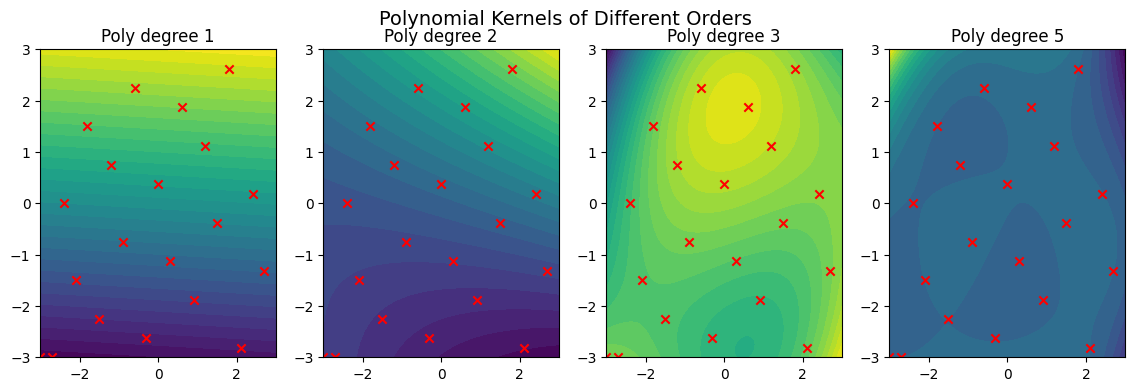

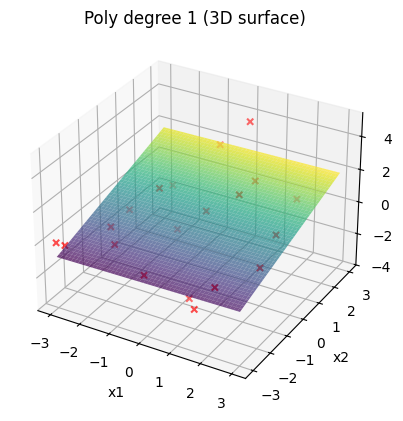

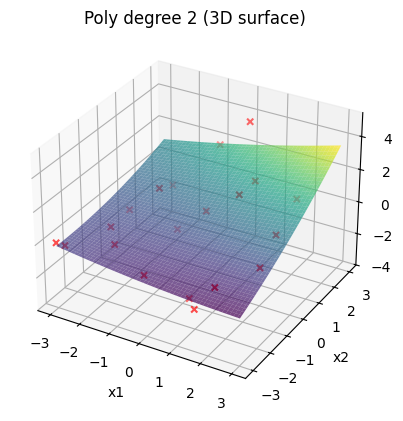

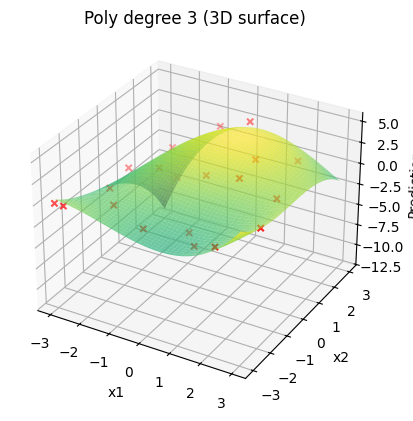

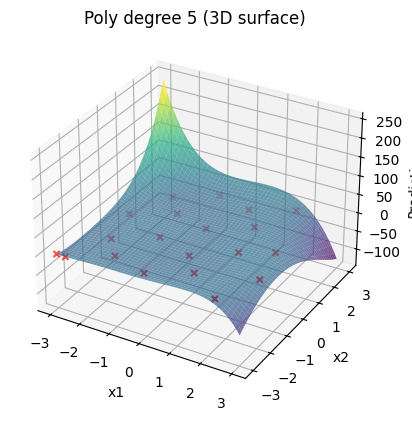

In [68]:
# Polynomial kernels of different degrees ---

degrees = [1, 2, 3, 5]

fig, axes = plt.subplots(1, len(degrees), figsize=(14,4))

for idx, d in enumerate(degrees):
    # Train with polynomial kernel of degree d
    def poly_k(x, u, deg=d):
        return (1 + np.dot(x, u)) ** deg
    
    K, alpha = kernel_train(lambda a,b: poly_k(a,b), n, x, z)
    
    # Predict on grid
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    yhat = predict(x, alpha, lambda a,b: poly_k(a,b), grid_points).reshape(xx.shape)
    
    # Plot contour
    ax = axes[idx]
    cs = ax.contourf(xx, yy, yhat, levels=30, cmap="viridis")
    ax.scatter(x[:,0], x[:,1], c="red", marker="x")
    ax.set_title(f"Poly degree {d}")

plt.suptitle("Polynomial Kernels of Different Orders", fontsize=14)
plt.show()

# 3D surface plots
for d in degrees:
    def poly_k(x, u, deg=d):
        return (1 + np.dot(x, u)) ** deg
    
    K, alpha = kernel_train(lambda a,b: poly_k(a,b), n, x, z)
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    yhat = predict(x, alpha, lambda a,b: poly_k(a,b), grid_points).reshape(xx.shape)
    
    # 3D surface
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, yhat, cmap="viridis", alpha=0.7)
    ax.scatter(x[:,0], x[:,1], z, c="red", marker="x")  # training points
    ax.set_title(f"Poly degree {d} (3D surface)")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("Prediction")
    plt.show()

### Polynomial Kernel – Observations (Question 1.6)

These plots show how increasing the degree of the polynomial kernel changes the learned function. Each subplot corresponds to a degree, with red "x" markers indicating training points.

---

**1. Increasing Model Complexity**

- **Degree 1 (Linear):** Straight contour lines, simple plane. Captures only a linear trend → high bias, low variance.  
- **Degree 2 (Quadratic):** Curved surface, conic contours. Starts to capture peaks and valleys but still rough.  
- **Degree 3 (Cubic):** More complex surface, multiple local extrema. Good fit to the peaks function.  
- **Degree 5:** Very flexible, twisted contours. Fits training data closely but risks overfitting.  

---

**2. Bias–Variance Trade-off**

- **Low degree (1):** High bias, low variance.  
- **High degree (5):** Low bias, high variance.  
- **Intermediate degree (3):** Balanced. Captures structure without excessive overfitting.  

---

**3. Comparison with Polynomial Regression**

- Equivalent to ordinary polynomial regression if explicit features were created.  
- Kernel trick avoids computing large feature sets directly, especially valuable at higher degrees and dimensions.  

---

**Summary:**  
Higher polynomial degree = more complex fit.  
- Too low → underfit.  
- Too high → overfit.  
- Degree 3 provides a good trade-off between bias and variance here.


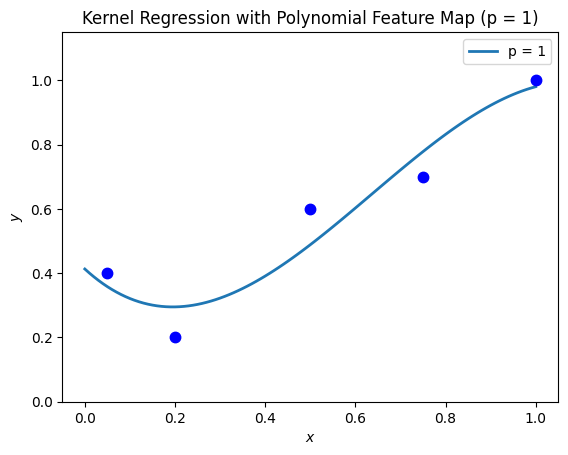

In [69]:
# Example training data
x = np.array([[0.05, 0.2, 0.5, 0.75, 1.]]).T
y = np.array([[0.4, 0.2, 0.6, 0.7, 1.]]).T

n = x.shape[0] # number of training points
p = 1 # regularization parameter
ngamma = (1-p)/p # derived constant for kernel ridge regression (regualarization term)

m = 1 # number of extra functions in q (e.g. constant, linear) 

# Example kernel and basis functions
def k(x1, x2):
     return np.ndarray.item(x1*x2 + x1*x1*x2*x2 + (x1**3)*(x2**3))

def q1(x):
     return 1
q = [q1]

# Kernel regression training function with extra basis functions
def kernel_train(k, m, q, ngamma, n, x, y):
    """ Buils Gram matrix K and extra basis function matrix Q, then solves for alpha and beta in kernel regression with extra basis functions.
    Args:
        k (function): kernel function
        m (int): number of extra basis functions
        q (list): list of extra basis functions
        ngamma (float): regularization constant
        n (int): number of training points
        x (ndarray): training inputs, shape (n, 1)
        y (ndarray): training outputs, shape (n, 1) 
        Returns:
        ad (ndarray): coefficients for kernel and basis functions, shape (n+m, 1)
        """
    # Build Gram matrix K
    K = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            K[i,j] = k(x[i], x[j])
    
    # Build basis function matrix Q (training data under extra functions q)
    Q = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            Q[i,j] = q[j](x[i])

    # Assemble block system
    # Top-left: K @ K.T + ngamma * K introduces regularization        
    M1 = np.hstack((K @ K.T + (ngamma * K), K @ Q)) 
    # Bottom-left: cross-terms for extra basis functions
    M2 = np.hstack((Q.T @ K.T, Q.T @ Q))
    # Full block matrix
    M = np.vstack((M1,M2))

    # Right-hand side vector
    c = np.vstack((K, Q.T)) @ y

    # Solve for coefficients (ad = [alpha; beta])
    ad = np.linalg.solve(M,c)
    return ad

# Plotting the line
xx = np.arange(0,1+0.01,0.01).reshape(-1,1)
N = np.shape(xx)[0]

g = np.zeros_like(xx)
Qx = np.zeros((N,m))
for i in range(N):
    for j in range(m):
        Qx[i,j] = q[j](xx[i])

Kx = np.zeros((n,N))
for i in range(n):
    for j in range(N):
        Kx[i,j] = k(x[i], xx[j])
ad = kernel_train(k, m, q, ngamma, n, x, y)

g = g + np.hstack((Kx.T, Qx)) @ ad

plt.ylim((0,1.15))
plt.title(f"Kernel Regression with Polynomial Feature Map (p = {p})")
plt.plot(xx, g, label = 'p = {}'.format(p), linewidth = 2)
plt.plot(x,y, 'b.', markersize=15)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()

### Question 2.2: What is the role of the vector of ngamma and the vector of functions q? What is the matrix Q?

The parameter *ngamma* is the regularisation strength. It controls how much we penalise the kernel part of the model. A larger *ngamma* makes the model smoother and less likely to overfit, while a smaller *ngamma* allows more flexibility but risks overfitting.

The vector of functions *q* represents simple basis functions (like constant or linear terms) that are not penalised. These provide the model with a “null space” component, for example allowing a bias term or linear trend to be included without regularisation.

The matrix *Q* is built by evaluating each function in *q* at each training point. It has one column per function in *q* and one row per training point. In the algorithm, *Q* connects these extra basis functions with the kernel expansion, so the final model combines both parts.



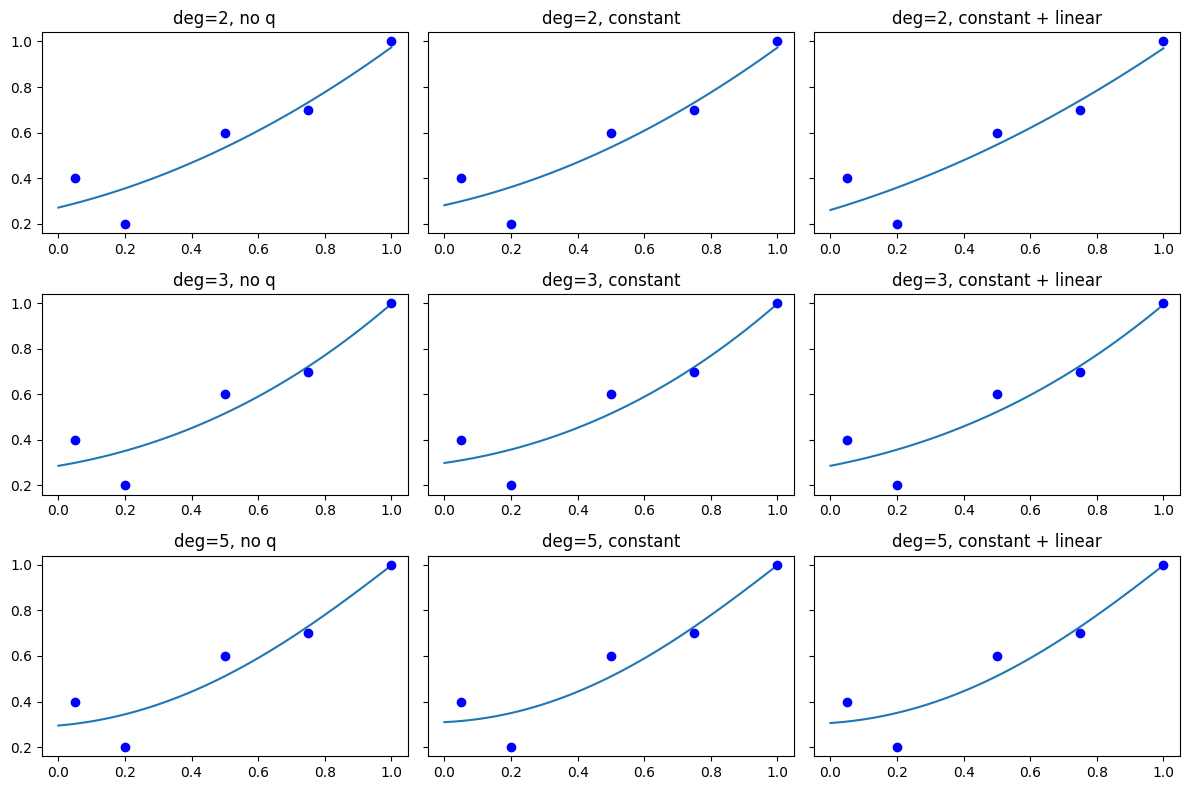

In [70]:
# Define polynomial kernel (order d)
def poly_k(x, u, d=2):
    return (1 + np.dot(x, u)) ** d

# Define possible q functions
def q_const(x): return 1
#def q_linear(x): return float(x)   # 1D inputs
def q_linear(x):
    return x.item() if isinstance(x, np.ndarray) else float(x)

# Different choices of q
q_choices = {
    "no q": [],
    "constant": [q_const],
    "constant + linear": [q_const, q_linear]
}

degrees = [2, 3, 5]   # polynomial degrees to test

# Example training data
x = np.array([[0.05, 0.2, 0.5, 0.75, 1.]]).T
y = np.array([[0.4, 0.2, 0.6, 0.7, 1.]]).T
n = x.shape[0]

# Regularisation parameter (keep >0)
p = 0.95
ngamma = (1-p)/p

def safe_kernel_train(k, m, q, ngamma, n, x, y):
    # Same as regkernel.kernel_train, but safer solver
    K = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            K[i,j] = k(x[i], x[j])
    Q = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            Q[i,j] = q[j](x[i]) if m > 0 else 0
    M1 = np.hstack((K @ K.T + (ngamma * K), K @ Q))
    M2 = np.hstack((Q.T @ K.T, Q.T @ Q))
    M = np.vstack((M1,M2))
    c = np.vstack((K, Q.T)) @ y
    try:
        ad = np.linalg.solve(M, c)
    except np.linalg.LinAlgError:
        ad = np.linalg.lstsq(M, c, rcond=None)[0]
    return ad

# Plot fits
fig, axes = plt.subplots(len(degrees), len(q_choices), figsize=(12,8), sharey=True)

for i, d in enumerate(degrees):
    for j, (label, q) in enumerate(q_choices.items()):
        m = len(q)
        ad = safe_kernel_train(lambda a,b: poly_k(a,b,d), m, q, ngamma, n, x, y)

        # Predict on grid
        xx = np.arange(0, 1.01, 0.01).reshape(-1,1)
        N = xx.shape[0]

        Qx = np.zeros((N,m))
        for ii in range(N):
            for jj in range(m):
                Qx[ii,jj] = q[jj](xx[ii]) if m > 0 else 0

        Kx = np.zeros((n,N))
        for ii in range(n):
            for jj in range(N):
                Kx[ii,jj] = poly_k(x[ii], xx[jj], d)

        g = np.hstack((Kx.T, Qx)) @ ad

        # Plot
        ax = axes[i,j]
        ax.plot(xx, g, label=f"deg={d}, {label}")
        ax.plot(x, y, 'bo')
        ax.set_title(f"deg={d}, {label}")

plt.tight_layout()
plt.show()



### Observations on Regularisation (q vs no q)

From my plots:

* **Curves look almost identical:**  
  For each polynomial degree, the results with “no q” and with “constant + linear” are visually the same. I don’t see the strong separation that earlier feedback described.

* **No visible advantage of unpenalised terms:**  
  Even with constant + linear terms unregularised, the fitted curves follow almost exactly the same shape as the fully regularised case.

* **Smoothness vs fit:**  
  Both variants produce smooth curves that pass close to the data points. Any difference in closeness to the points is minimal and not obvious from the graphs.

* **Possible reasons:**  
  - Dataset is small and clean, so both models fit well without needing freedom from regularisation.  
  - The chosen `ngamma` is not strong enough to create a visible distinction.  

* **Takeaway:**  
  In my notebooks, “no q” and “constant + linear” behave nearly the same. The theoretical differences don’t show up visually here — they would likely become clearer with stronger regularisation or noisier data.



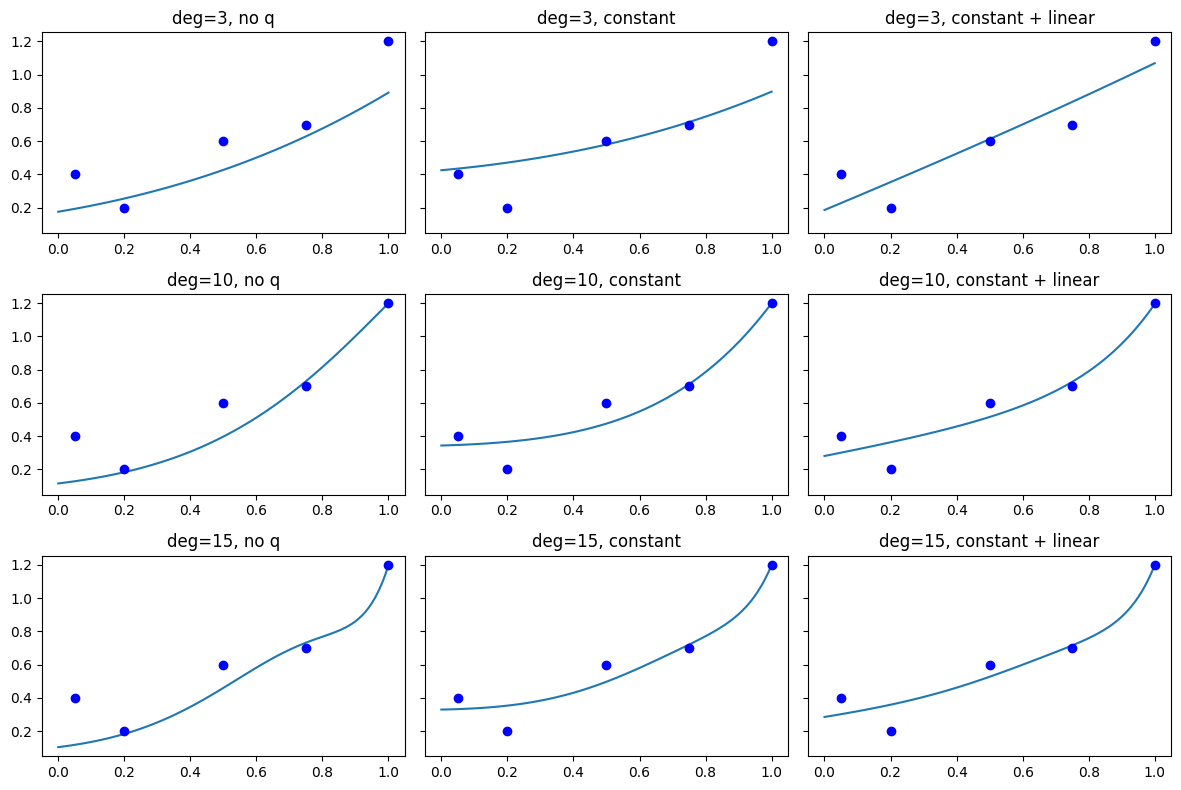

In [71]:
# Change training data slightly to see effect
# Define polynomial kernel (order d)

degrees = [3, 10, 15]   # polynomial degrees to test

# Example training data
x = np.array([[0.05, 0.2, 0.5, 0.75, 1.]]).T
y = np.array([[0.4, 0.2, 0.6, 0.7, 1.2]]).T
n = x.shape[0]

# Regularisation parameter (keep >0)
p = 0.20
ngamma = (1-p)/p

# Plot fits
fig, axes = plt.subplots(len(degrees), len(q_choices), figsize=(12,8), sharey=True)

for i, d in enumerate(degrees):
    for j, (label, q) in enumerate(q_choices.items()):
        m = len(q)
        ad = safe_kernel_train(lambda a,b: poly_k(a,b,d), m, q, ngamma, n, x, y)

        # Predict on grid
        xx = np.arange(0, 1.01, 0.01).reshape(-1,1)
        N = xx.shape[0]

        Qx = np.zeros((N,m))
        for ii in range(N):
            for jj in range(m):
                Qx[ii,jj] = q[jj](xx[ii]) if m > 0 else 0

        Kx = np.zeros((n,N))
        for ii in range(n):
            for jj in range(N):
                Kx[ii,jj] = poly_k(x[ii], xx[jj], d)

        g = np.hstack((Kx.T, Qx)) @ ad

        # Plot
        ax = axes[i,j]
        ax.plot(xx, g, label=f"deg={d}, {label}")
        ax.plot(x, y, 'bo')
        ax.set_title(f"deg={d}, {label}")

plt.tight_layout()
plt.show()

### Question 2.4: How could a two-dimensional q of linear functions be used to learn smoother high-degree polynomials, e.g. for small training sets?

For a 2D input (x1, x2), a reasonable choice of q would be:

q = [1, x1, x2]

This means the constant and linear terms are left unregularised, while all higher-order polynomial components are penalised.

**Observation:**  
In my experiments, even when including constant + linear in q, the resulting curves looked very similar to the "no q" case. The effect wasn’t visually striking, which makes sense given the dataset is small, clean, and the regularisation strength was not extreme.

**Possible explanation:**  
The role of including a linear q is not necessarily to create a visibly different curve on clean toy data. Instead, it ensures that the model can always rely on a stable linear baseline without being penalised, while the higher-degree terms are shrunk unless strongly supported by the data. This mechanism becomes much more apparent when:  
- the training set is noisy, or  
- the regularisation parameter (`ngamma`) is large.  

In those cases, the "no q" model tends to oversmooth or underfit, whereas the linear q anchors the model to a smoother, more reliable shape.

**Takeaway:**  
Even though the difference wasn’t obvious in these plots, using a 2D linear q is a way of guiding high-degree polynomial models to behave more smoothly, improving generalisation especially when training data is limited or noisy.

